In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from log_reg_util import one_hot, one_cold, softmax

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
data = pd.read_csv("data/data.csv", sep=' ')
target = pd.read_csv("data/target.csv", sep=' ')

In [4]:
X = data.values
y = np.array(one_hot(target.values, [0., 1.]))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

### Neural Network Pipeline

In [6]:
def sigmoid(val, threshold=0.5):
    """ Sigmoid function implementation """
    return 1/(1 + np.exp(-val))

def dsigmoid(val, threshold=0.5):
    """ Element-wise derivative of sigmoid function """
    sig = sigmoid(val, threshold)
    return sig * (1-sig)

In [7]:
def nll_alt(Y_true, Y_pred):
    EPSILON = 1e-10
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)

In [8]:
def accuracy(y_true, y_hot):
    # Compute accuracy for samples X with true labels y
    y_preds = np.argmax(y_hot, axis=1)
    return np.mean(np.equal(y_preds, y_true))

In [9]:
def forward_pass(W_, x_, b_):
    return x_.dot(W_) + b_
#     return x_.dot(W_)

In [10]:
def forward_keep_activations(x_, Wh_, bh_, Wo_, bo_):
    z_h = forward_pass(Wh_, x_, bh_)
    h = np.apply_along_axis(sigmoid, 0, z_h)
    z_o = forward_pass(Wo_, h, bo_)
    y = np.apply_along_axis(softmax, 0, z_o)
    return y, h, z_h, z_o

In [11]:
def grad_loss(x_, y_hot, Wh_, bh_, Wo_, bo_):
    y, h, z_h, _ = forward_keep_activations(x_, Wh_, bh_, Wo_, bo_)

    grad_z_o = (y - y_hot) * dsigmoid(y)
#     grad_z_o = y - y_hot
    grad_W_o = np.outer(h, grad_z_o)
    grad_b_o = grad_z_o
    
    grad_h = np.dot(grad_z_o, np.transpose(Wo_))
    grad_z_h = grad_h * dsigmoid(z_h)
    grad_W_h = np.outer(x_, grad_z_h)
    grad_b_h = grad_z_h
       
    return grad_W_h, grad_b_h, grad_W_o, grad_b_o, nll_alt(y_hot, y)

In [12]:
def train(X_, y_hot, model = None, learning_rate = 0.005):
    input_size = X_.shape[1] 
    output_size = y_hot.shape[1]
    hidden_size = 20
    
    if model is None:
        W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01) 
        b_h = np.zeros(hidden_size) 
        W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01)
        b_o = np.zeros(output_size)
    else:
        W_h, b_h, W_o, b_o = model
    
    losses = []
    for i, (x_, y_) in enumerate(zip(X_, y_hot)):
        grad_W_h, grad_b_h, grad_W_o, grad_b_o, loss = grad_loss(x_, y_, W_h, b_h, W_o, b_o)
        W_h = W_h - learning_rate * grad_W_h
        b_h = b_h - learning_rate * grad_b_h
        W_o = W_o - learning_rate * grad_W_o
        b_o = b_o - learning_rate * grad_b_o
        
        losses.append(loss)  
        
    return [W_h, b_h, W_o, b_o, np.mean(losses)]

In [13]:
def train_epochs(X_train_, X_test_, y_train_, y_test_, n_epochs, learning_rate = 0.005, report_interval = None):

    training = None
    accuracies = []
    losses = []

    for i in range(n_epochs):
        
        report = True if (report_interval is not None and i % report_interval == 0) else False
        
        training = train(X_train_, y_train_, training, learning_rate = learning_rate)
        loss = training.pop(-1)
        predictions = forward_keep_activations(X_test_, *training)[0]
        acc = accuracy(one_cold(y_test_), predictions)
        accuracies.append(acc)
        losses.append(loss)

        if report:
            print("=========================================")
            print("Accuracy after training: \t{:.2f}%".format(100*(acc)))
            print("Average loss after training: \t{:.4e}".format(loss))

    predictions = forward_keep_activations(X_test_, *training)[0]
    
    return training, predictions, accuracies, losses

---

In [14]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [15]:
def print_scores(y_true_, y_pred_):
    print("ROC/AUC score: {:.2f}%".format(100*roc_auc_score(y_true_, y_pred_)))
    print("Accuracy score: {:.2f}%".format(100*accuracy_score(y_true_, y_pred_)))
    print("F1 score: {:.2f}%".format(100*f1_score(y_true_, y_pred_)))

In [16]:
weights, pred, acc, loss = train_epochs(X_train, X_val, y_train, y_val, 20, learning_rate = 0.15, report_interval = 5)

Accuracy after training: 	88.10%
Average loss after training: 	3.8595e-01
Accuracy after training: 	88.70%
Average loss after training: 	3.1531e-01
Accuracy after training: 	88.30%
Average loss after training: 	3.1887e-01
Accuracy after training: 	76.50%
Average loss after training: 	2.8911e-01


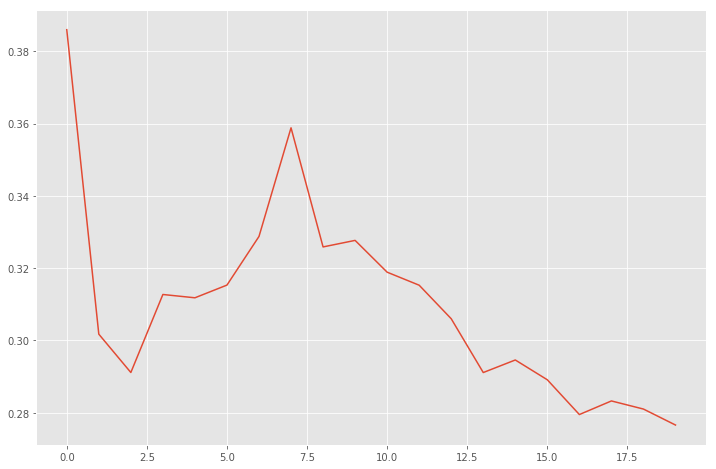

In [17]:
plt.plot(loss)

In [18]:
print_scores(one_cold(y_val), one_cold(pred))

ROC/AUC score: 60.68%
Accuracy score: 62.60%
F1 score: 73.55%


In [19]:
test_pred = forward_keep_activations(X_test, *weights)

In [20]:
# pd.DataFrame(X_val)[one_cold(y_val) != one_cold(pred)]